In [1]:
options(repr.plot.width = 12, repr.plot.height = 6)

# EX 10.2

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



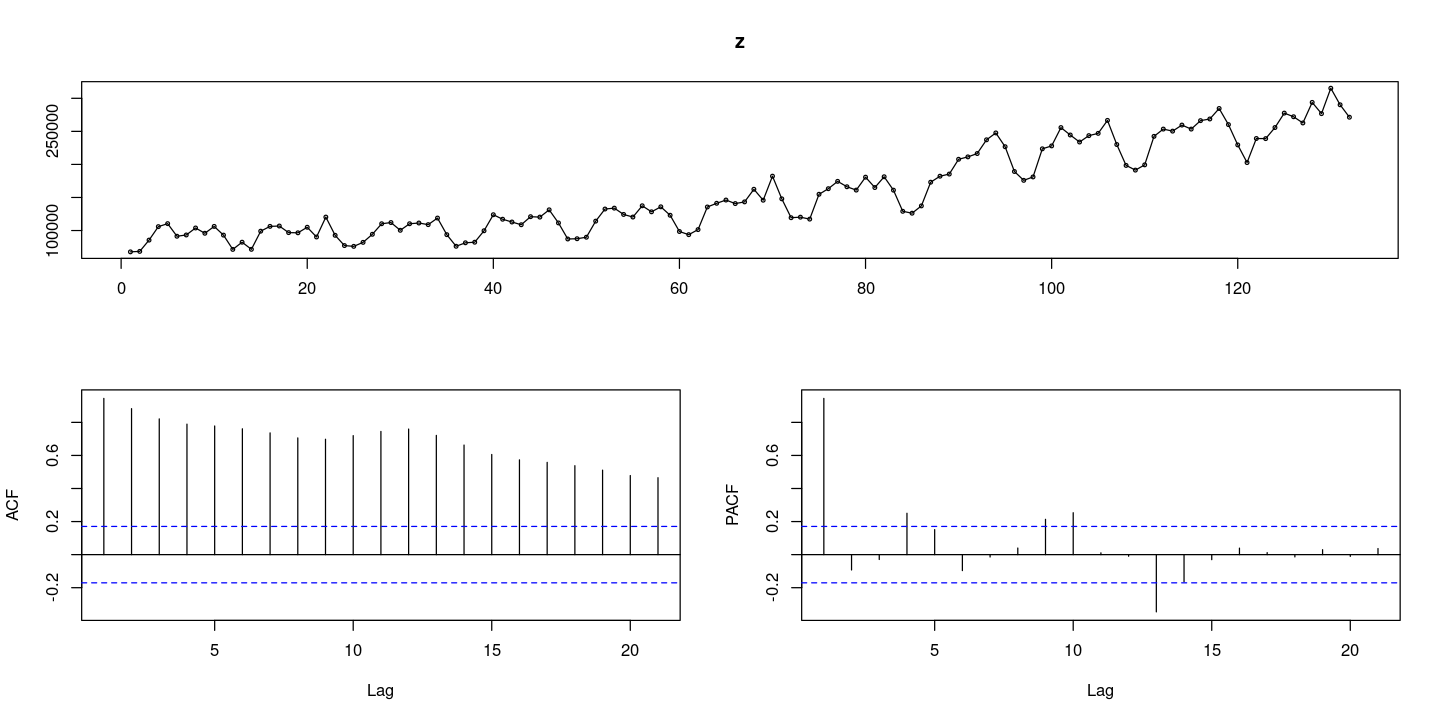

In [2]:
z <- scan("tourist.txt")
forecast::tsdisplay(z)


- 이분산성, 추세와 계절성분을 모두 가지고 있다.

- 변수변환을 통한 분산안정화 부터 진행

- ACF천천히 감소(계절성분이 있어서 봉긋하게 솟아오르는 그림: 계절차분 필요해)

## (1) 분산안정화 : 변수변환

In [3]:
log_z = log(z)
sqrt_z = sqrt(z)
boxcox_z = forecast::BoxCox(z,lambda= forecast::BoxCox.lambda(z))

In [4]:
forecast::BoxCox.lambda(z)

[1] 0.5975034

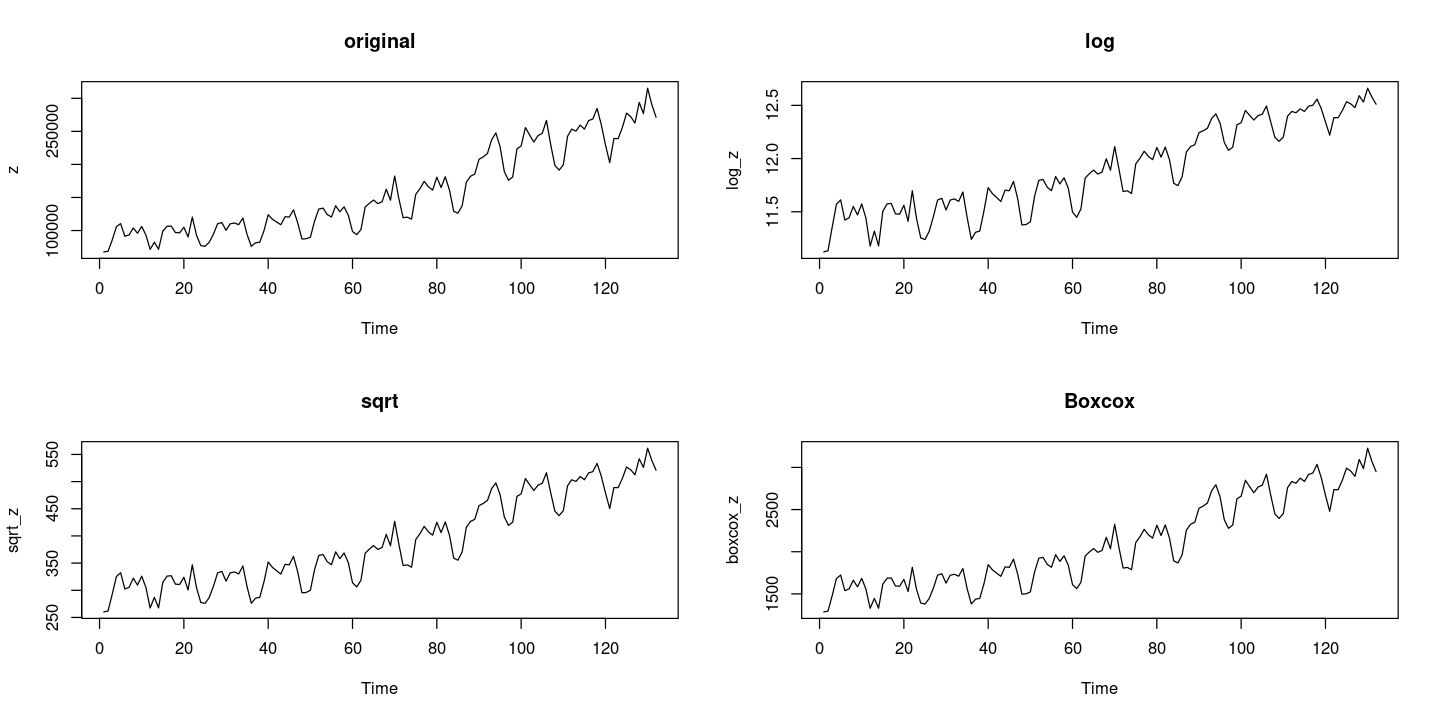

In [5]:
par(mfrow=c(2,2))
plot.ts(z, main = "original")
plot.ts(log_z, main = 'log')
plot.ts(sqrt_z, main = 'sqrt')
plot.ts(boxcox_z, main = 'Boxcox')

In [6]:
t = 1:length(z)
lmtest::bptest(lm(z~t)) #H0 : 등분산이다
lmtest::bptest(lm(log_z~t))
lmtest::bptest(lm(sqrt_z~t))
lmtest::bptest(lm(boxcox_z~t))


	studentized Breusch-Pagan test

data:  lm(z ~ t)
BP = 1.574, df = 1, p-value = 0.2096



	studentized Breusch-Pagan test

data:  lm(log_z ~ t)
BP = 5.4539, df = 1, p-value = 0.01953



	studentized Breusch-Pagan test

data:  lm(sqrt_z ~ t)
BP = 0.26821, df = 1, p-value = 0.6045



	studentized Breusch-Pagan test

data:  lm(boxcox_z ~ t)
BP = 0.026422, df = 1, p-value = 0.8709


- 원데이터도 등분산이긴 하지만.. sqrt나 boxcox를 하는게 나은 것 같다.

- $\lambda = 0.597$을 이용한 Boxcox 변환 수행

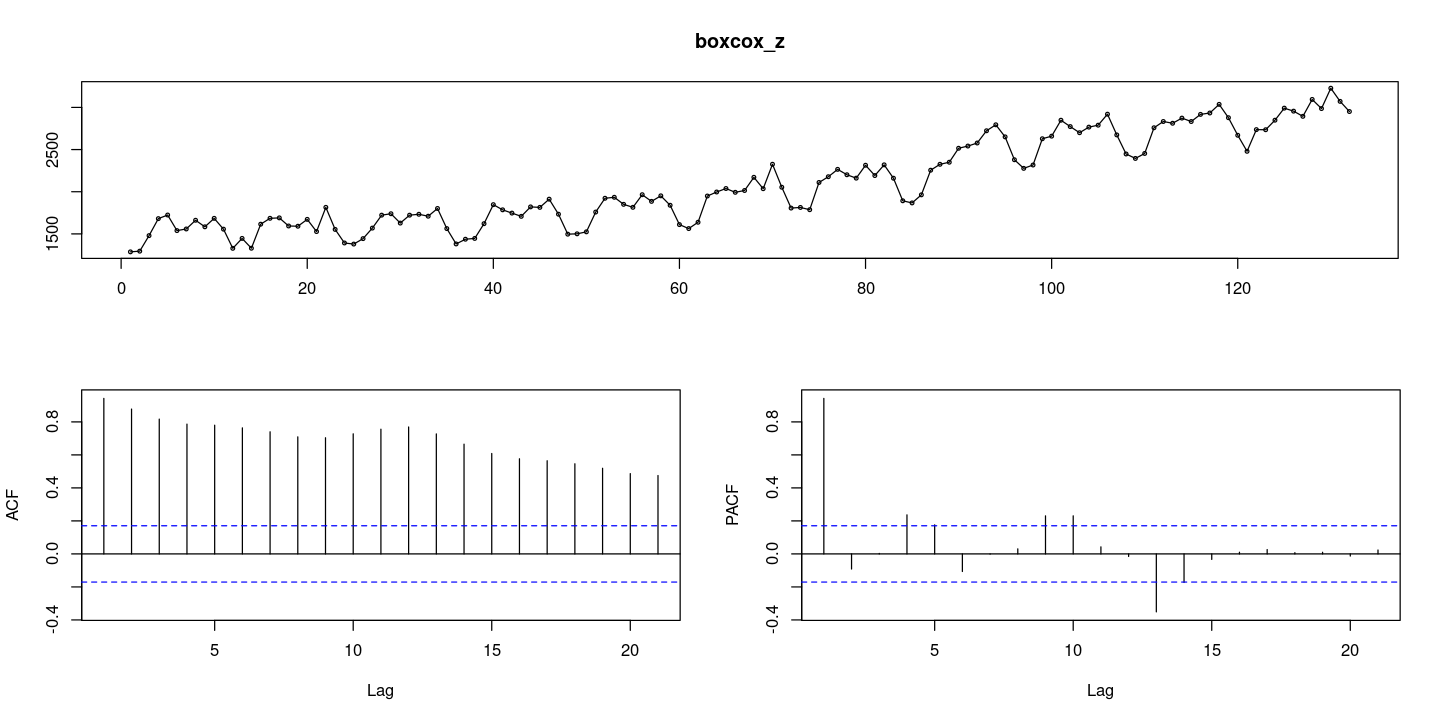

In [7]:
forecast::tsdisplay(boxcox_z)

- 계절성분과 추세가 존재하므로 우선 계절차분을 통한 계절성분 제거

## (2) 계절차분

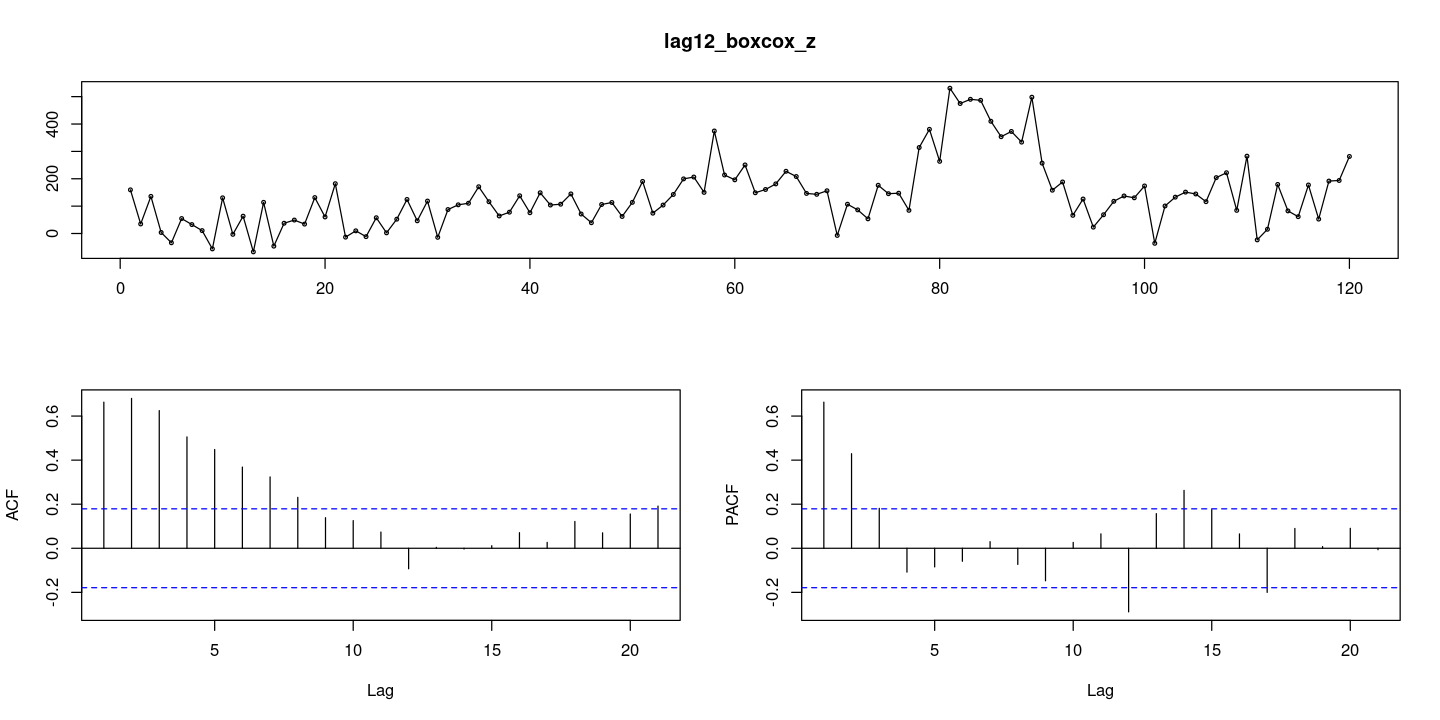

In [8]:
lag12_boxcox_z = diff(boxcox_z, lag=12)
forecast::tsdisplay(lag12_boxcox_z)

- 계절차분을 통해 결정적 계절추세는 제거 되었음

- 결정적 추세는 없는 것으로 보이나, ACF가 조금은 천천히 감소하는 경향이 보이기 때문에 단위근 검정을 통해
차분이 필요한가에 대한 여부 판정


## 평균

In [37]:
t.test(lag12_boxcox_z)


	One Sample t-test

data:  lag12_boxcox_z
t = 12.508, df = 119, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 116.3801 160.1566
sample estimates:
mean of x 
 138.2684 


- 평균 0아님

## (3) 단위근 검정

In [9]:
##단위근 검정 : H0 : 단위근이 있다.
fUnitRoots::adfTest(lag12_boxcox_z, lags = 1, type = "c")



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -2.6696
  P VALUE:
    0.08535 

Description:
 Tue Dec  5 20:44:51 2023 by user: 

- 유의확률이 아주 크지는 않지만, 유의수준 $\alpha=0.05$하에서 귀무가설을 기각하지 못하기 때문에 차분을 하기로함, 단위근이 있어!


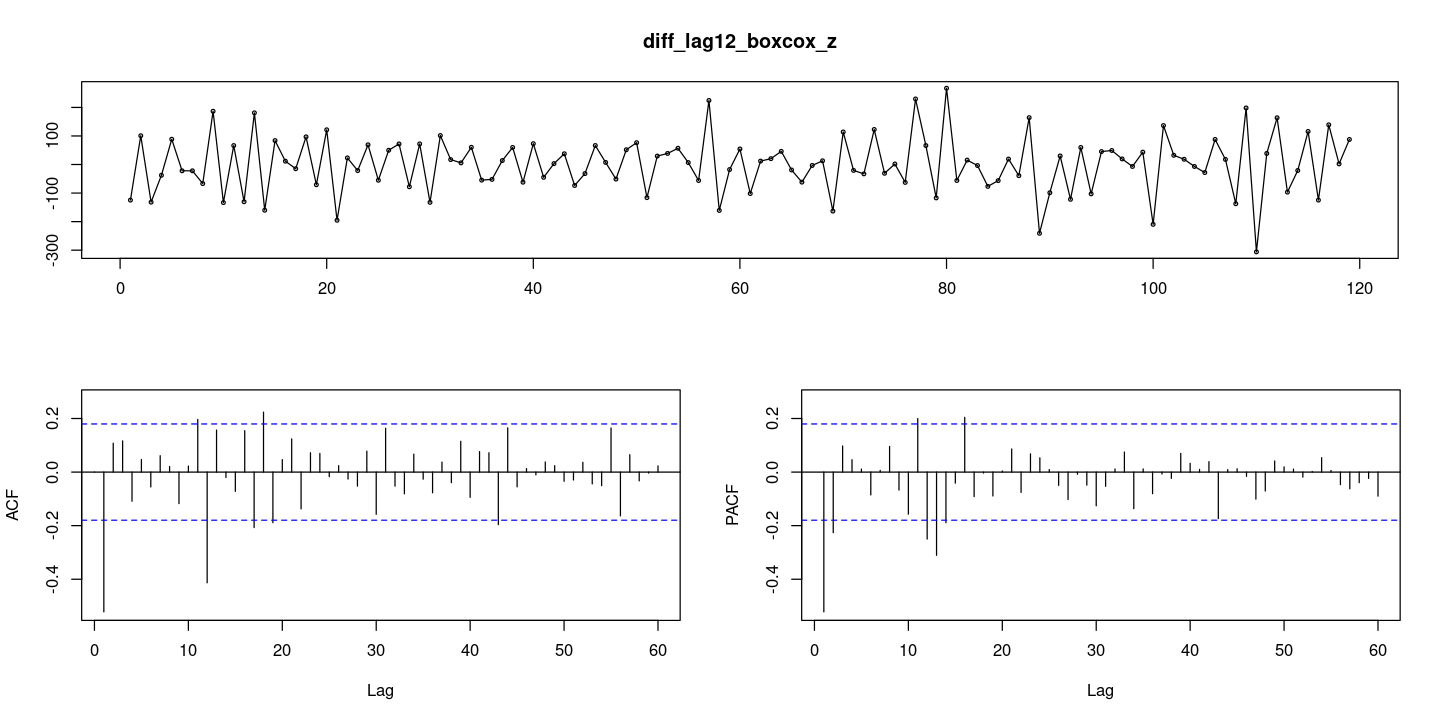

In [38]:
diff_lag12_boxcox_z = diff(lag12_boxcox_z)
forecast::tsdisplay(diff_lag12_boxcox_z, lag.max=60)


- 차분한 후의 자료에 대해서는 더이상 차분이 필요하지 않음


## (4) 모형식별

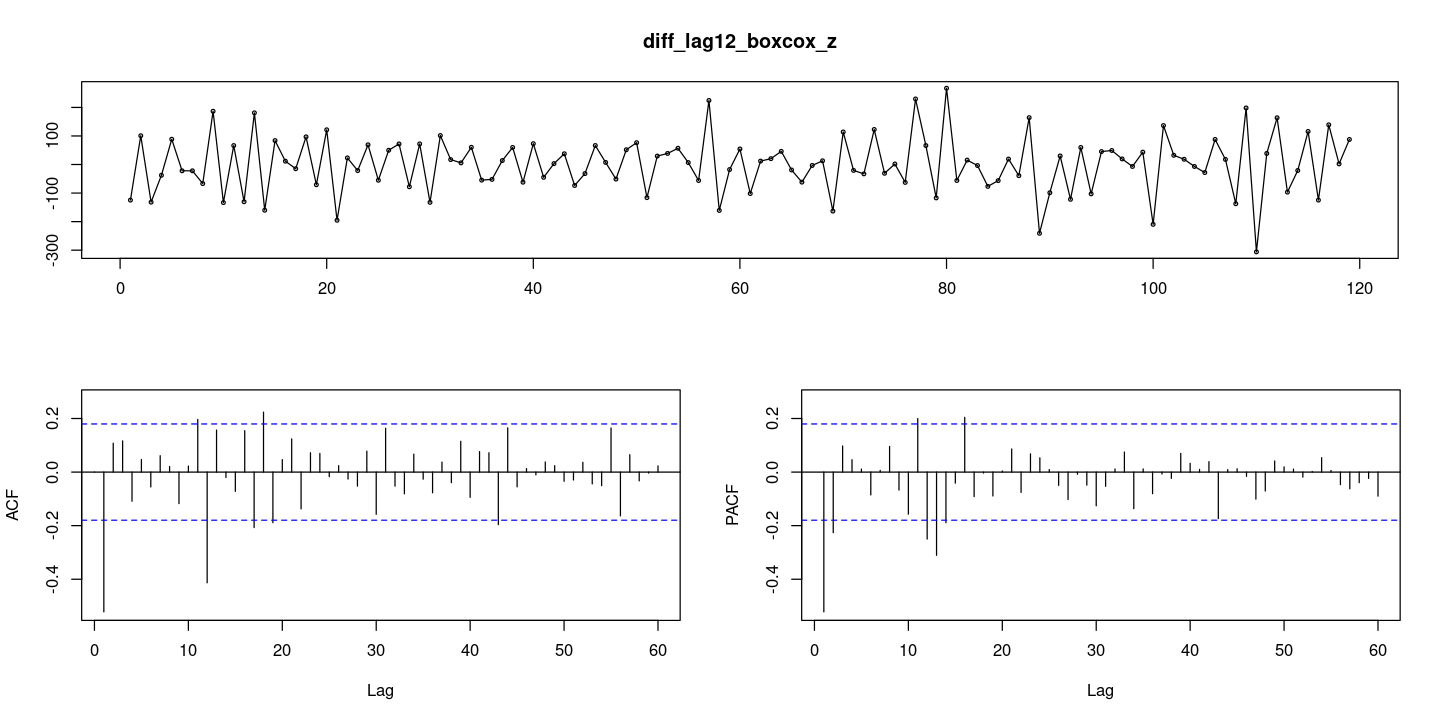

In [39]:
forecast::tsdisplay(diff_lag12_boxcox_z, lag.max=60)

- ACF는 1차와 12차에서 절단 형태이고, PACF는 1,2차와 12,13 시차 등에서 유의하게 나왔다.

- ACF의 차수가 더 낮으므로 MA(1)과 계절형 MA(1)모형을 적합할 수 있다.

- diff_lag12_boxcox_z = : $ARIMA(0, 0, 1)(0, 0, 1)_{12}$

- lag12_boxcox_z = $ARIMA(0,1,1)(0,0,1)_{12}$

- Boxcox_z = $ARIMA(0,1,1)(0,1,1)_{12}$

- 계절형 AR도 괜찮을 것 같다.

## (5) 모형적합

`-` 상수항 추가 여부 확인

In [45]:
t.test(diff_lag12_boxcox_z)


	One Sample t-test

data:  diff_lag12_boxcox_z
t = 0.11301, df = 118, p-value = 0.9102
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -16.93470  18.98455
sample estimates:
mean of x 
 1.024925 


- 상수항 추가 안해두 된당.

`-` 모형1

In [44]:
fit11 = arima(diff_lag12_boxcox_z, order = c(0,0,1), include.mean=F,
     seasonal = list(order = c(0,0,1), period=12))
fit11


Call:
arima(x = diff_lag12_boxcox_z, order = c(0, 0, 1), seasonal = list(order = c(0, 
    0, 1), period = 12), include.mean = F)

Coefficients:
          ma1     sma1
      -0.5307  -0.6370
s.e.   0.0702   0.0842

sigma^2 estimated as 4831:  log likelihood = -676.87,  aic = 1359.74

`-` 모형2

In [43]:
fit12 = arima(lag12_boxcox_z, order = c(0,1,1),
     seasonal = list(order = c(0,0,1), period=12))
fit12


Call:
arima(x = lag12_boxcox_z, order = c(0, 1, 1), seasonal = list(order = c(0, 0, 
    1), period = 12))

Coefficients:
          ma1     sma1
      -0.5307  -0.6370
s.e.   0.0702   0.0842

sigma^2 estimated as 4831:  log likelihood = -676.87,  aic = 1359.74

`-` 모형3

In [13]:
fit1 = arima(boxcox_z, order = c(0,1,1),
     seasonal = list(order = c(0,1,1), period=12))
fit1


Call:
arima(x = boxcox_z, order = c(0, 1, 1), seasonal = list(order = c(0, 1, 1), 
    period = 12))

Coefficients:
          ma1     sma1
      -0.5307  -0.6370
s.e.   0.0702   0.0842

sigma^2 estimated as 4831:  log likelihood = -676.87,  aic = 1359.74

- 위의 3개 모형의 값은 동일하게 나온다.

In [48]:
lmtest::coeftest(fit1) #원데이터에 적합하는게 좋다.(forecast하기 위해서)


z test of coefficients:

      Estimate Std. Error z value  Pr(>|z|)    
ma1  -0.530740   0.070154 -7.5654 3.868e-14 ***
sma1 -0.637038   0.084175 -7.5680 3.790e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


- 모든 계수가 유의하다.

$(1 − B)(1 − B^{12})BoxCox(Z) = (1 − 0.5307B)(1 − 0.6370B^{12})ε_t, ε+t ∼ WN(0, 4831)$

- MA부분, SMA부분이 있다.

## (6) 잔차분석


	Ljung-Box test

data:  Residuals from ARIMA(0,1,1)(0,1,1)[12]
Q* = 9.1519, df = 8, p-value = 0.3296

Model df: 2.   Total lags used: 10



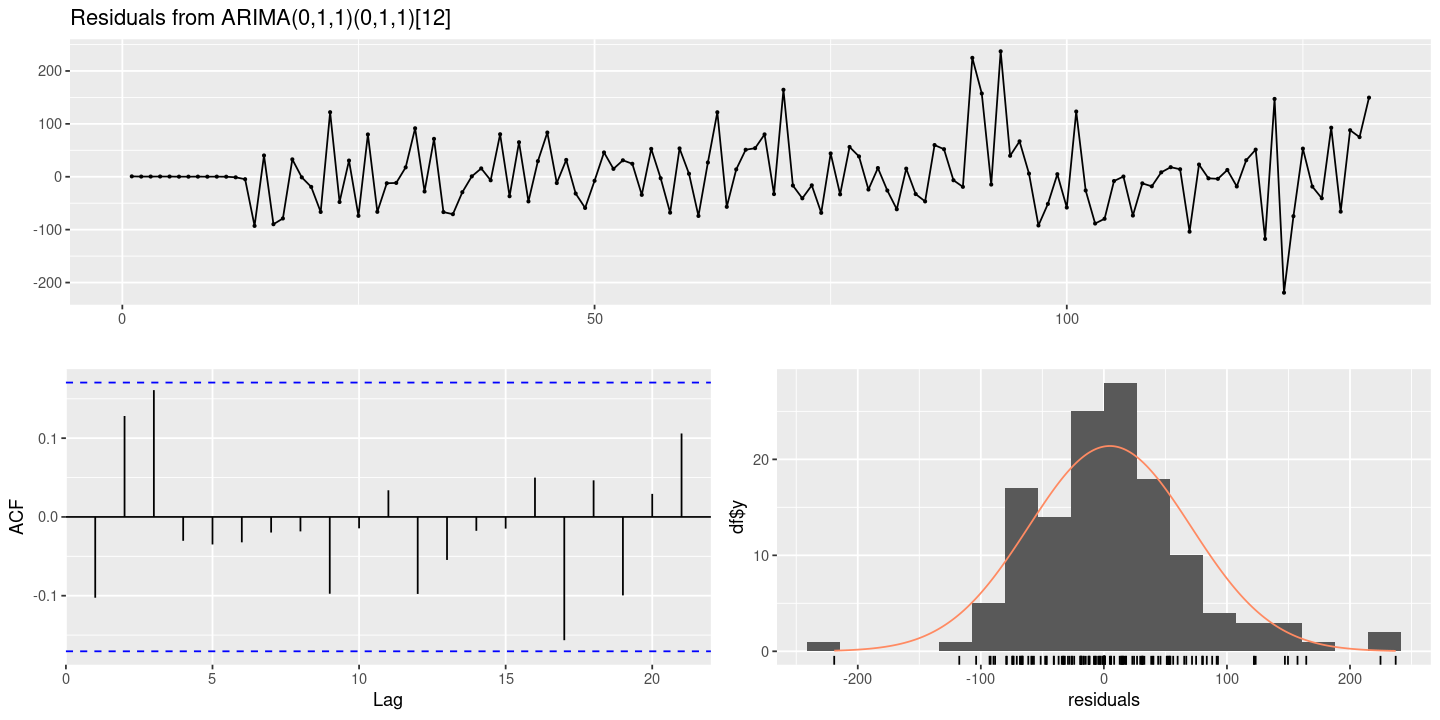

In [15]:
forecast::checkresiduals(fit1)

- 잔차의 평균은 0이다

In [16]:
t.test(resid(fit1))


	One Sample t-test

data:  resid(fit1)
t = 0.83993, df = 131, p-value = 0.4025
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -6.546096 16.206445
sample estimates:
mean of x 
 4.830174 


- 등분산성을 만족하고, ACF가 모든 시차에서 유의하지 않으므로 WN라고 할 수 있다.

`-` 포투맨투검정

In [17]:
#모형 적합도 검정 : H0 : rho1=...=rho_k=0
Box.test(resid(fit1), lag=1, type = "Ljung-Box")
Box.test(resid(fit1), lag=6, type = "Ljung-Box")
Box.test(resid(fit1), lag=12, type = "Ljung-Box")


	Box-Ljung test

data:  resid(fit1)
X-squared = 1.4198, df = 1, p-value = 0.2334



	Box-Ljung test

data:  resid(fit1)
X-squared = 7.6505, df = 6, p-value = 0.2648



	Box-Ljung test

data:  resid(fit1)
X-squared = 10.729, df = 12, p-value = 0.5523


- 모든 시차에 대해 유의확률값이 크기 때문에 WN라고 할 수 있다.

In [19]:
# 잔차의 포트맨토 검정 ## H0 : rho1=...=rho_k=0
portes::LjungBox(fit1, lags=c(6,12,18,24))

,lags,statistic,df,p-value
,6,7.650531,5,0.1765764
,12,10.728871,11,0.4662493
,18,15.730829,17,0.5429906
,24,25.724146,23,0.3140605


## (7) 과대적합

- boxcox_z = $ARIMA(0,1,1)(0,1,1)_{12}$

- $ARIMA(1,1,1)(0,1,1)_{12}, ARIMA(0,1,2)(0,1,1)_{12}$

- $ARIMA(0,1,1)(1,0,1)_{12}$

`-` AR추가

In [20]:
fit2 <- arima(boxcox_z, order = c(1,1,1),
     seasonal = list(order = c(0,1,1), period=12))
fit2


Call:
arima(x = boxcox_z, order = c(1, 1, 1), seasonal = list(order = c(0, 1, 1), 
    period = 12))

Coefficients:
          ar1      ma1     sma1
      -0.3345  -0.2984  -0.6183
s.e.   0.1354   0.1299   0.0828

sigma^2 estimated as 4658:  log likelihood = -674.51,  aic = 1357.01

In [21]:
lmtest::coeftest(fit2)


z test of coefficients:

      Estimate Std. Error z value  Pr(>|z|)    
ar1  -0.334453   0.135431 -2.4695   0.01353 *  
ma1  -0.298389   0.129851 -2.2979   0.02157 *  
sma1 -0.618253   0.082802 -7.4666 8.228e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


`-` MA추가

In [22]:
fit3 <- arima(boxcox_z, order = c(0,1,2),
     seasonal = list(order = c(0,1,1), period=12))
fit3



Call:
arima(x = boxcox_z, order = c(0, 1, 2), seasonal = list(order = c(0, 1, 1), 
    period = 12))

Coefficients:
          ma1     ma2     sma1
      -0.6445  0.2825  -0.6236
s.e.   0.0871  0.1009   0.0833

sigma^2 estimated as 4569:  log likelihood = -673.44,  aic = 1354.88

In [23]:
lmtest::coeftest(fit3)


z test of coefficients:

      Estimate Std. Error z value  Pr(>|z|)    
ma1  -0.644484   0.087127 -7.3970 1.393e-13 ***
ma2   0.282478   0.100937  2.7985  0.005133 ** 
sma1 -0.623576   0.083259 -7.4896 6.908e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


`-` 계절형 AR

In [49]:
fit4 <- arima(boxcox_z, order = c(0,1,1),
     seasonal = list(order = c(1,1,0), period=12))
fit4



Call:
arima(x = boxcox_z, order = c(0, 1, 1), seasonal = list(order = c(1, 1, 0), 
    period = 12))

Coefficients:
          ma1     sar1
      -0.5583  -0.5525
s.e.   0.0670   0.0804

sigma^2 estimated as 5011:  log likelihood = -678.13,  aic = 1362.25

In [50]:
lmtest::coeftest(fit4)


z test of coefficients:

      Estimate Std. Error z value  Pr(>|z|)    
ma1  -0.558307   0.067012 -8.3315 < 2.2e-16 ***
sar1 -0.552549   0.080366 -6.8754 6.181e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [24]:
fit1


Call:
arima(x = boxcox_z, order = c(0, 1, 1), seasonal = list(order = c(0, 1, 1), 
    period = 12))

Coefficients:
          ma1     sma1
      -0.5307  -0.6370
s.e.   0.0702   0.0842

sigma^2 estimated as 4831:  log likelihood = -676.87,  aic = 1359.74

`-` AIC가 제일 작은 모형 선택

- $ARIMA(0,1,2)(0,1,1)_{12}$모형 적합 결과가 더 좋기 때문에 최종 모형으로 선택


	Ljung-Box test

data:  Residuals from ARIMA(0,1,2)(0,1,1)[12]
Q* = 3.3401, df = 7, p-value = 0.8519

Model df: 3.   Total lags used: 10



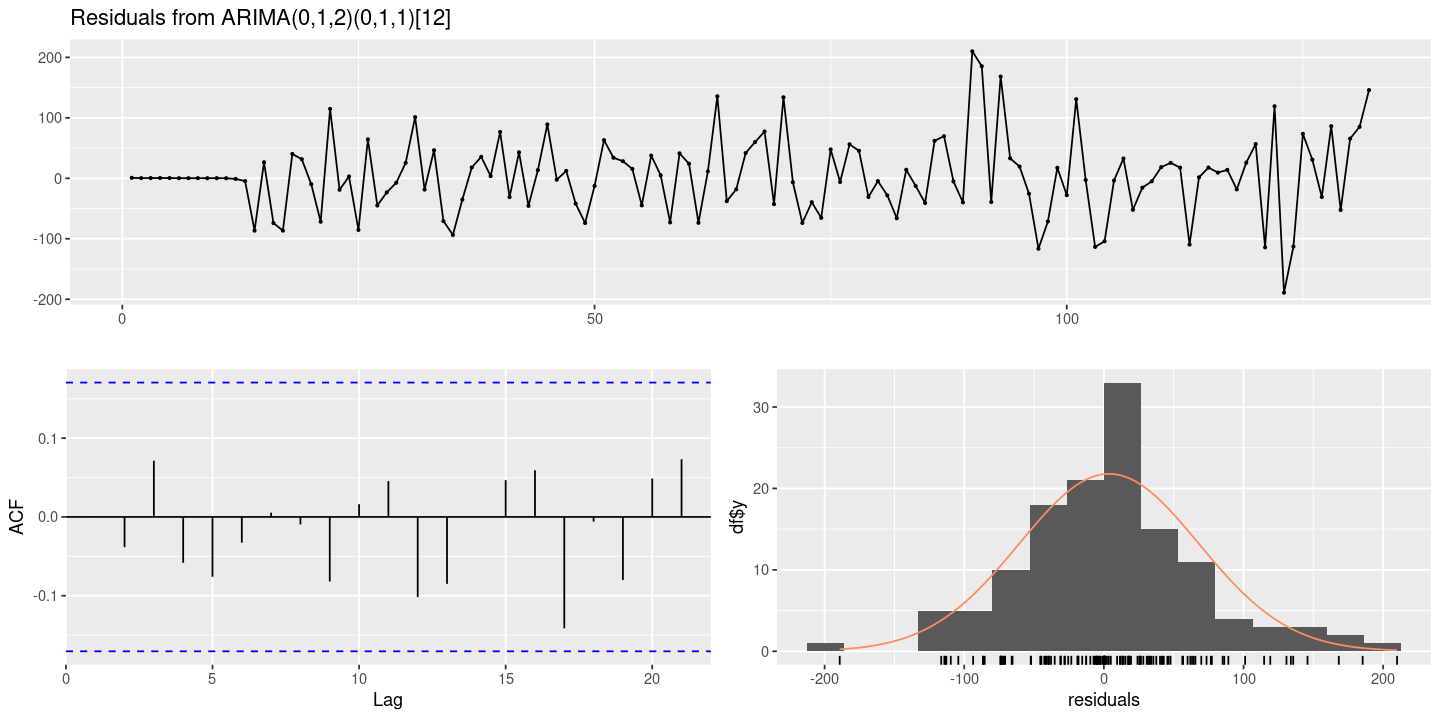

In [25]:
forecast::checkresiduals(fit3)

In [26]:
#모형 적합도 검정 : H0 : rho1=...=rho_k=0
Box.test(resid(fit3), lag=1, type = "Ljung-Box")
Box.test(resid(fit3), lag=6, type = "Ljung-Box")
Box.test(resid(fit3), lag=12, type = "Ljung-Box")


	Box-Ljung test

data:  resid(fit3)
X-squared = 0.00013728, df = 1, p-value = 0.9907



	Box-Ljung test

data:  resid(fit3)
X-squared = 2.3206, df = 6, p-value = 0.888



	Box-Ljung test

data:  resid(fit3)
X-squared = 5.1674, df = 12, p-value = 0.9522


- 잔차검정 결과도 이상이 없으므로 fit3을 최종모형으로 선택

In [67]:
fit3


Call:
arima(x = boxcox_z, order = c(0, 1, 2), seasonal = list(order = c(0, 1, 1), 
    period = 12))

Coefficients:
          ma1     ma2     sma1
      -0.6445  0.2825  -0.6236
s.e.   0.0871  0.1009   0.0833

sigma^2 estimated as 4569:  log likelihood = -673.44,  aic = 1354.88

- $(1-B)(1-B^{12})Z_t = (1  -0.6445 B + 0.2825 B^2)(1-0.6236 B^{12}) \epsilon_t$

- 부호 반대인거 조심!

## (8) auto.arima

In [27]:
forecast::auto.arima(ts(boxcox_z, frequency=12),
                     test = "adf",
                     seasonal = TRUE, trace = T)


 ARIMA(2,1,2)(1,1,1)[12]                    : 1357.774
 ARIMA(0,1,0)(0,1,0)[12]                    : 1432.23
 ARIMA(1,1,0)(1,1,0)[12]                    : 1360.54
 ARIMA(0,1,1)(0,1,1)[12]                    : 1359.953
 ARIMA(2,1,2)(0,1,1)[12]                    : 1358.211
 ARIMA(2,1,2)(1,1,0)[12]                    : 1359.268
 ARIMA(2,1,2)(2,1,1)[12]                    : 1359.649
 ARIMA(2,1,2)(1,1,2)[12]                    : 1358.941
 ARIMA(2,1,2)(0,1,0)[12]                    : 1394.751
 ARIMA(2,1,2)(0,1,2)[12]                    : 1358.288
 ARIMA(2,1,2)(2,1,0)[12]                    : 1359.606
 ARIMA(2,1,2)(2,1,2)[12]                    : 1361.251
 ARIMA(1,1,2)(1,1,1)[12]                    : 1356.533
 ARIMA(1,1,2)(0,1,1)[12]                    : 1357.41
 ARIMA(1,1,2)(1,1,0)[12]                    : 1357.649
 ARIMA(1,1,2)(2,1,1)[12]                    : Inf
 ARIMA(1,1,2)(1,1,2)[12]                    : Inf
 ARIMA(1,1,2)(0,1,0)[12]                    : 1393.906
 ARIMA(1,1,2)(0,1,2)[1

Series: ts(boxcox_z, frequency = 12) 
ARIMA(0,1,2)(1,1,1)[12] 

Coefficients:
          ma1     ma2     sar1     sma1
      -0.6662  0.2996  -0.3012  -0.4028
s.e.   0.0880  0.0997   0.1645   0.1751

sigma^2 = 4601:  log likelihood = -671.9
AIC=1353.79   AICc=1354.32   BIC=1367.69

In [28]:
fit4 <- forecast::auto.arima(ts(boxcox_z, frequency=12),
                             test = "adf",
                             seasonal = TRUE)


In [29]:
lmtest::coeftest(fit4)


z test of coefficients:

      Estimate Std. Error z value  Pr(>|z|)    
ma1  -0.666226   0.088010 -7.5699 3.734e-14 ***
ma2   0.299594   0.099683  3.0055  0.002652 ** 
sar1 -0.301227   0.164489 -1.8313  0.067058 .  
sma1 -0.402808   0.175098 -2.3005  0.021421 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


- 최종선택 모형에 비해 aic나 분산이 조금 작지만 추가된 계수가 유의하지 않으므로 기존 모형 유지

## (9) 예측

In [30]:
fore_fit <- forecast::forecast(fit3, 24)

In [31]:
fore_fit

    Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
133       2780.444 2693.821 2867.067 2647.966 2912.923
134       2948.470 2856.536 3040.404 2807.869 3089.071
135       3133.218 3025.951 3240.484 2969.168 3297.267
136       3219.609 3098.943 3340.275 3035.067 3404.151
137       3304.710 3171.991 3437.429 3101.734 3507.686
138       3299.345 3155.579 3443.110 3079.474 3519.215
139       3256.562 3102.541 3410.584 3021.007 3492.118
140       3385.280 3221.644 3548.916 3135.020 3635.540
141       3349.803 3177.087 3522.520 3085.657 3613.950
142       3514.000 3332.658 3695.342 3236.661 3791.339
143       3340.552 3150.976 3530.129 3050.621 3630.484
144       3151.776 2954.309 3349.243 2849.776 3453.776
145       3024.749 2808.612 3240.886 2694.196 3355.302
146       3167.091 2940.850 3393.332 2821.085 3513.096
147       3351.838 3113.152 3590.525 2986.799 3716.878
148       3438.230 3187.715 3688.744 3055.101 3821.358
149       3523.330 3261.522 3785.139 3122.929 3923.732
150       

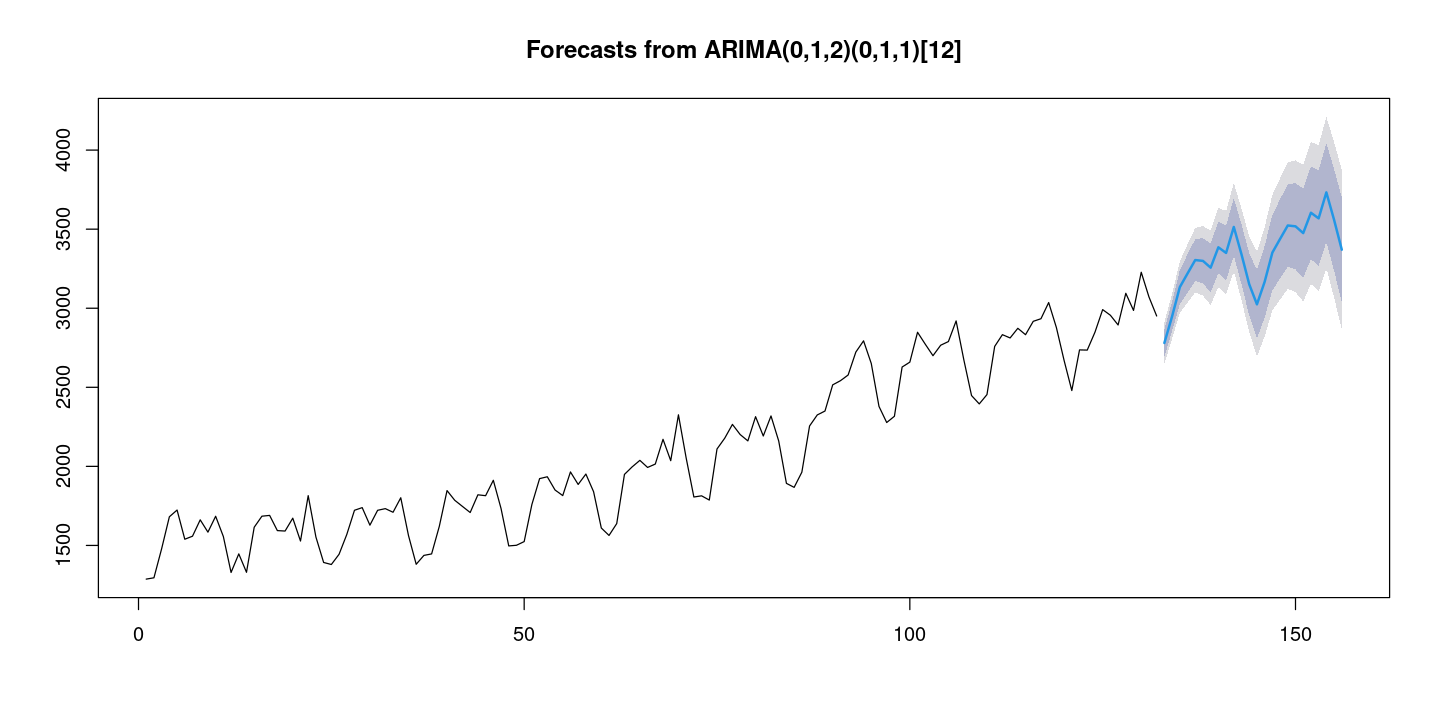

In [32]:
plot(fore_fit)

$pred
Time Series:
Start = 133 
End = 156 
Frequency = 1 
 [1] 2780.444 2948.470 3133.218 3219.609 3304.710 3299.345 3256.562 3385.280
 [9] 3349.803 3514.000 3340.552 3151.776 3024.749 3167.091 3351.838 3438.230
[17] 3523.330 3517.965 3475.183 3603.901 3568.424 3732.621 3559.173 3370.397

$se
Time Series:
Start = 133 
End = 156 
Frequency = 1 
 [1]  67.59220  71.73660  83.70024  94.15583 103.56115 112.18066 120.18358
 [8] 127.68587 134.77119 141.50216 147.92719 154.08445 168.65254 176.53675
[15] 186.24806 195.47750 204.29040 212.73853 220.86375 228.70048 236.27743
[22] 243.61884 250.74540 257.67482

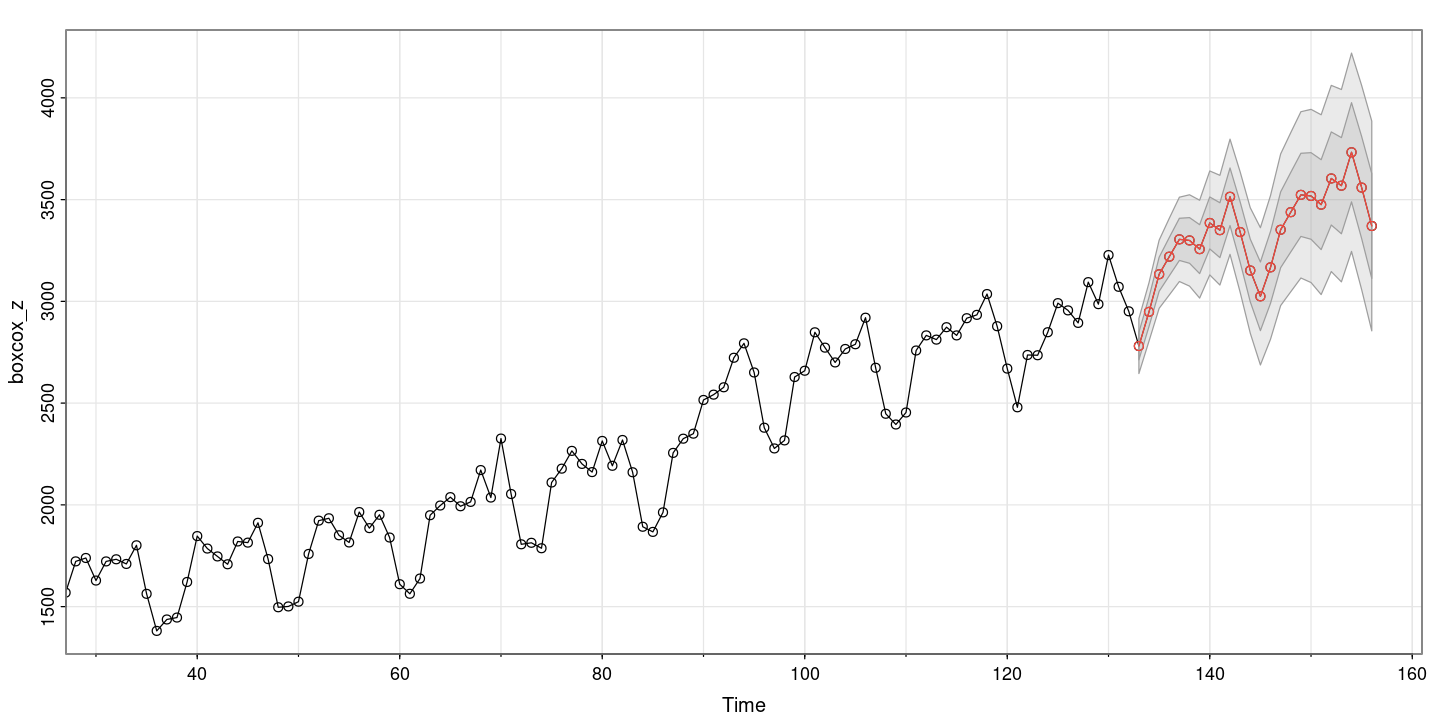

In [33]:
astsa::sarima.for(boxcox_z, 24, p=0,d=1,q=2,P=0, D=1, Q=1, S=12)

- BoxCox 역변환을 해야함

In [34]:
forecast_z = forecast::InvBoxCox(fore_fit$mean, lambda=forecast::BoxCox.lambda(z))
forecast_z


A Time Series:
 [1] 245634.2 270964.3 299958.6 313921.3 327924.4 327034.3 319971.6 341407.6
 [9] 335443.8 363400.0 333895.6 302936.5 282791.7 305402.8 335784.7 350387.4
[17] 365015.5 364086.2 356709.7 379086.0 372864.1 402007.3 371248.5 338900.5

In [35]:
forecast_z_upper95 = forecast::InvBoxCox(fore_fit$upper[,2], lambda=forecast::BoxCox.lambda(z))
forecast_z_lower95 = forecast::InvBoxCox(fore_fit$lower[,2], lambda=forecast::BoxCox.lambda(z))


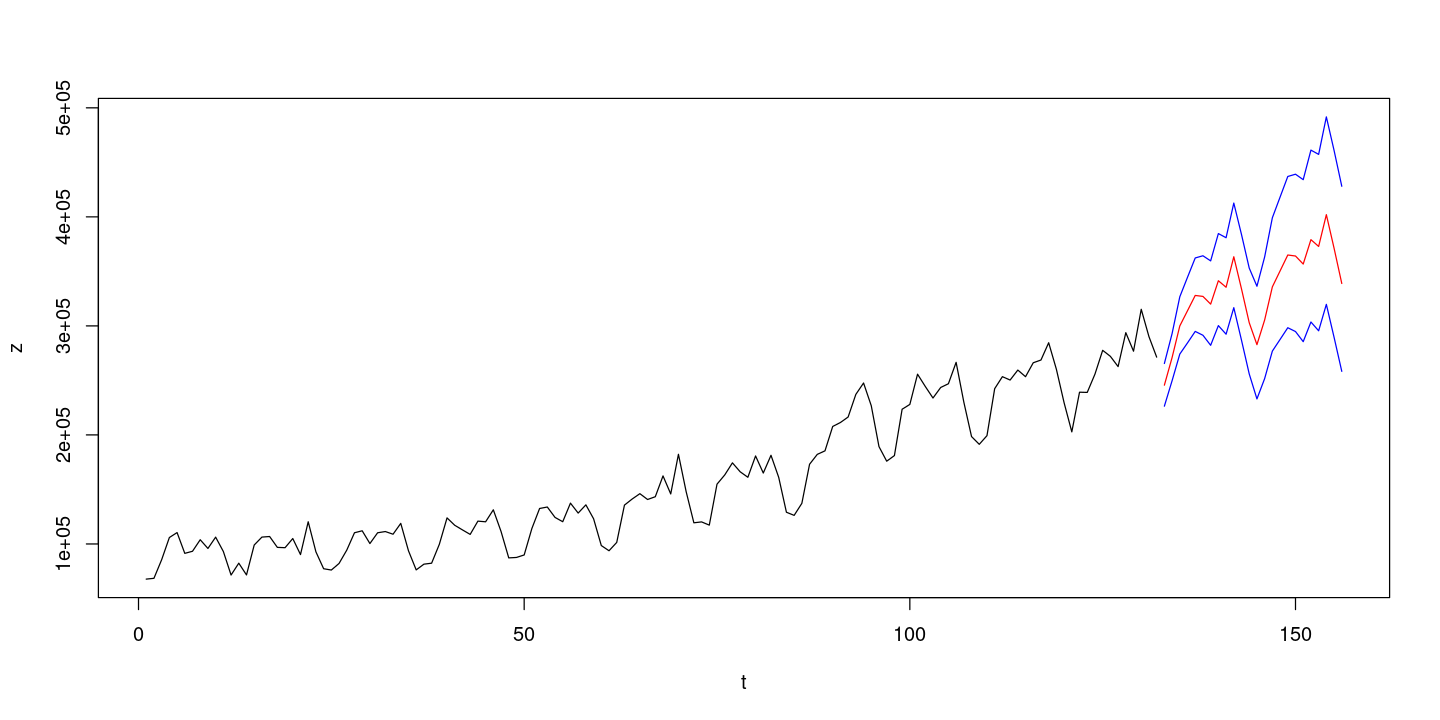

In [51]:
plot(1:(length(z)+24), c(z, forecast_z_upper95), type='n', xlab='t', ylab='z')
lines(1:length(z),z)
lines((length(z)+1) : (length(z)+24), forecast_z, col='red')
lines((length(z)+1) : (length(z)+24), forecast::InvBoxCox(fore_fit$lower[,2], lambda=forecast::BoxCox.lambda(z)), col='blue')
lines((length(z)+1) : (length(z)+24), forecast::InvBoxCox(fore_fit$upper[,2], lambda=forecast::BoxCox.lambda(z)), col='blue')


# Simulation

In [52]:
# astsa::sarima.sim(ar = NULL, d = 0, ma = NULL, sar = NULL, D = 0, sma = NULL, S = NULL,
# n = 500, rand.gen = rnorm, innov = NULL, burnin = NA, t0 = 0, ...)



# sarima::sim_sarima(model=list(ar,iorder,ma, sar, siorder, sma, nseasons, sigma2),
# n = NA, rand.gen = rnorm, n.start = NA, x, eps,
                   
# xcenter = NULL, xintercept = NULL, ...)


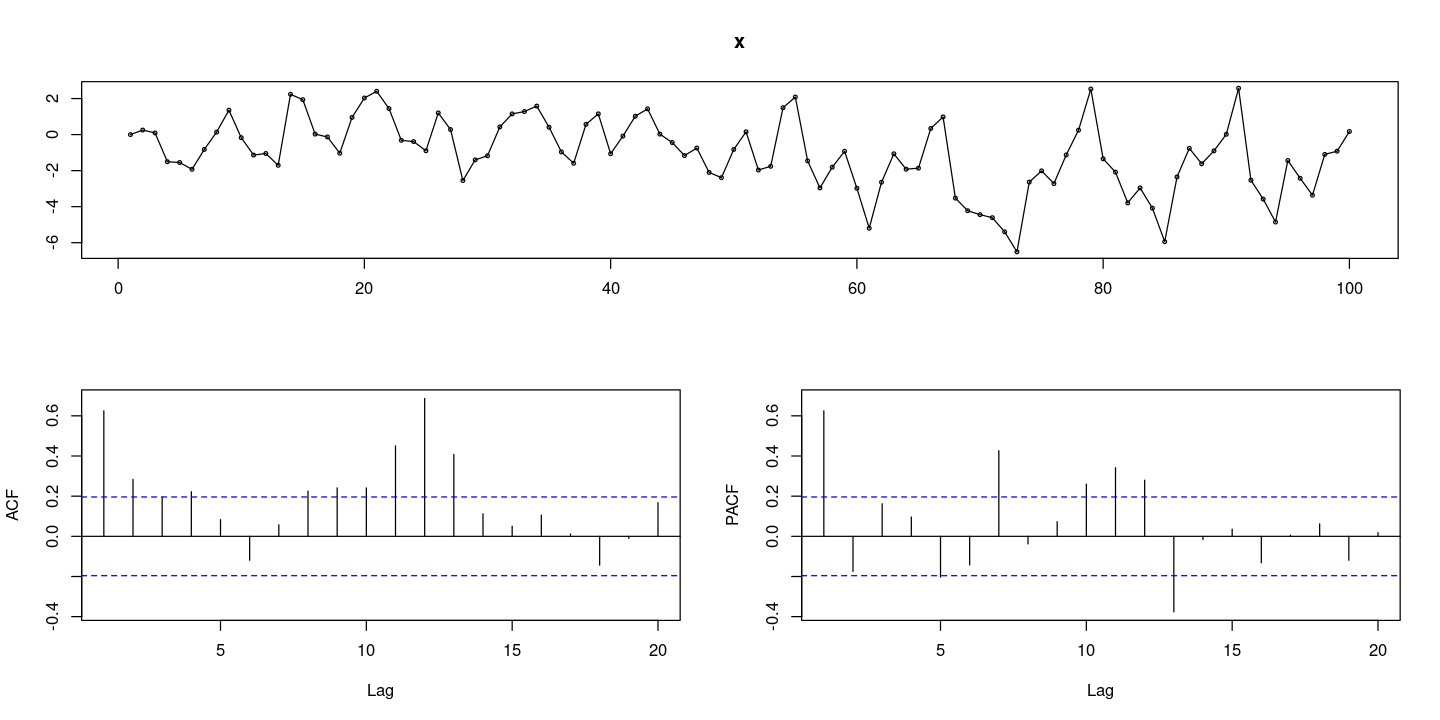

In [66]:
### ARIMA(p,d,q)(P,D,Q)_s
x <- sarima::sim_sarima(n=100, n.start=12,
                         model=list(ar = 0.7, siorder=1, nseasons=12, sigma2 = 1)) # SMA(1)
forecast::tsdisplay(x)

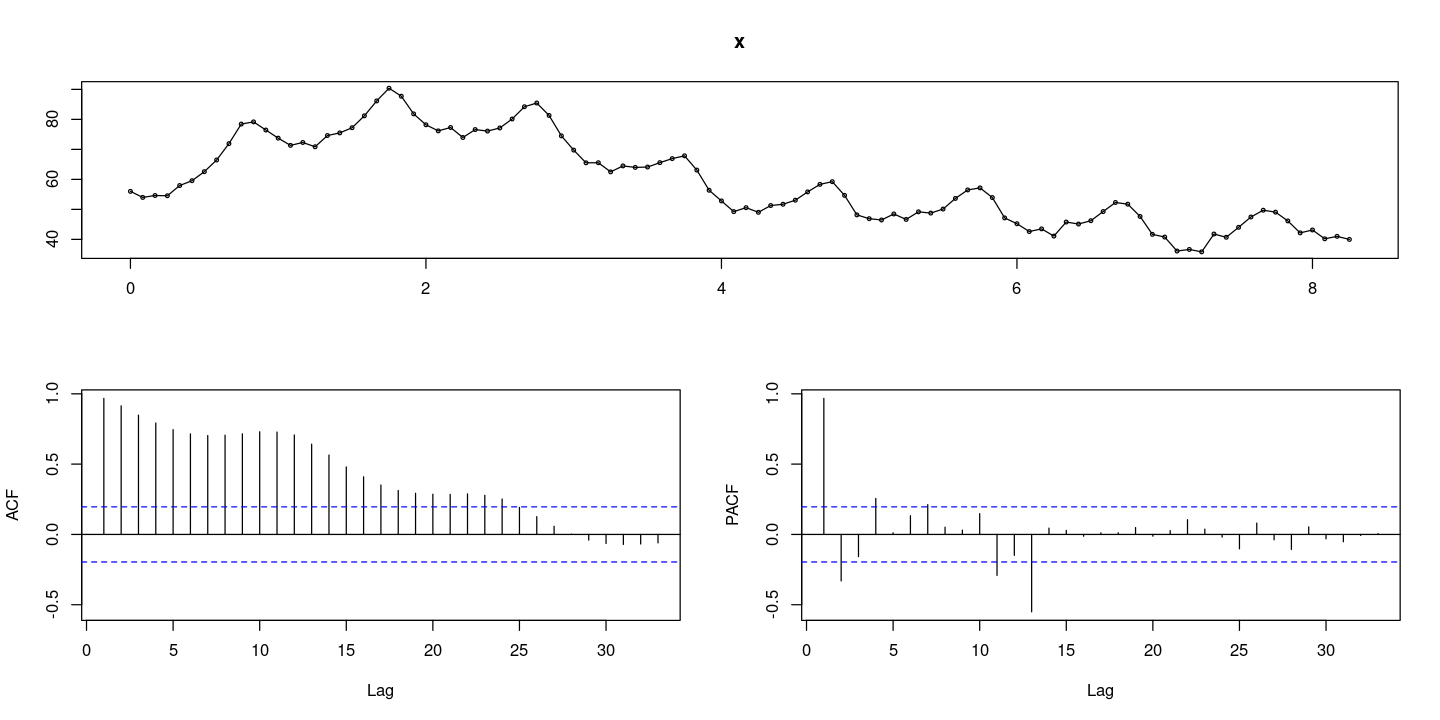

In [54]:
x <- astsa::sarima.sim(ar = 0.5, d = 1, ma = 0.1, sar = 0.1, D = 1, sma = 0, S = 12, n = 100)
forecast::tsdisplay(x)